## Global Average Pooling 적용

채널 단위로 average 하여 값을 뽑아냄

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2, l1_l2

IMAGE_SIZE = 32

# 0~1 사이값의 float32로 변경하는 함수
def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# 0~1 사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)


def create_model(verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    # Flatten 대신 Global AveragePooling 을 적용.
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)

    if verbose:
        model.summary()

    return model

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(histroy):
    plt.figure(figsize=(8,4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

In [6]:
# CIFAR10 데이터 재 로딩 및 Scaling/OHE 전처리 적용하여 학습/검증/데이터 세트 생성. 
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


In [8]:
model = create_model()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),
                    callbacks=[rlr_cb, ely_cb])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1329/1329 [==============================] - 72s 30ms/step - loss: 1.4648 - accuracy: 0.4666 - val_loss: 1.7329 - val_accuracy: 0.4717
Epoch 2/30
1329/1329 [==============================] - 38s 29ms/step - loss: 1.0545 - accuracy: 0.6256 - val_loss: 1.1053 - val_accuracy: 0.6140
Epoch 3/30
1329/1329 [==============================] - 38s 29ms/step - loss: 0.8648 - accuracy: 0.6965 - val_loss: 0.8847 - val_accuracy: 0.6949
Epoch 4/30
1329/1329 [==============================] - 38s 29ms/step - loss: 0.7318 - accuracy: 0.7499 - val_loss: 1.0620 - val_accuracy: 0.6440
Epoch 5/30
1329/1329 [==============================] - 38s 28ms/step - loss: 0.6282 - accuracy: 0.7887 - val_loss: 0.8709 - val_accuracy: 0.7224
Epoch 6/30
1329/1329 [==============================] - 38s 29ms/step - loss: 0.5468 - accuracy: 0.8143 - val_loss: 0.6564 - val_accuracy: 0.7743
Epoch 7/30
1329/1329 [==============================] - 37s 28ms/step - loss: 0.4758 - accuracy: 0.8386 - val_loss: 0.8739 -

313/313 [==============================] - 3s 10ms/step - loss: 0.7036 - accuracy: 0.8576


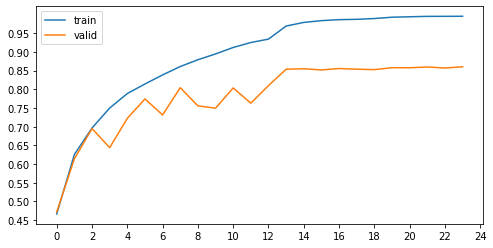

In [9]:
model.evaluate(test_images, test_oh_labels)
show_history(history)

### 가중치 규제

개별 layer 별로 tensorflow.keras.regularizers의 l1, l2, l1_l2를 이용하여 가중치 규제를 적용할 수 있음

In [11]:
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

#x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.00001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=128, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = Activation('relu')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(1e-5))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)


x = Flatten(name='flatten')(x)
x = Dropout(rate=0.5)(x)
x = Dense(300, activation='relu', kernel_regularizer=l2(1e-5), name='fc1')(x)
x = Dropout(rate=0.2)(x)
output = Dense(10, activation='softmax', name='output')(x)

model = Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 64)        0   

In [12]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)


history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
1329/1329 [==============================] - 44s 32ms/step - loss: 1.5315 - accuracy: 0.4631 - val_loss: 1.5538 - val_accuracy: 0.4803
Epoch 2/30
1329/1329 [==============================] - 42s 32ms/step - loss: 1.1062 - accuracy: 0.6299 - val_loss: 1.0680 - val_accuracy: 0.6645
Epoch 3/30
1329/1329 [==============================] - 42s 32ms/step - loss: 0.9499 - accuracy: 0.6938 - val_loss: 1.0339 - val_accuracy: 0.6741
Epoch 4/30
1329/1329 [==============================] - 42s 32ms/step - loss: 0.8461 - accuracy: 0.7355 - val_loss: 0.8480 - val_accuracy: 0.7440
Epoch 5/30
1329/1329 [==============================] - 42s 32ms/step - loss: 0.7803 - accuracy: 0.7667 - val_loss: 0.7674 - val_accuracy: 0.7831
Epoch 6/30
1329/1329 [==============================] - 42s 32ms/step - loss: 0.7226 - accuracy: 0.7948 - val_loss: 0.8150 - val_accuracy: 0.7747
Epoch 7/30
1329/1329 [==============================] - 42s 32ms/step - loss: 0.6735 - accuracy: 0.8212 - val_loss: 0.8212 -

313/313 [==============================] - 3s 11ms/step - loss: 0.8750 - accuracy: 0.8579


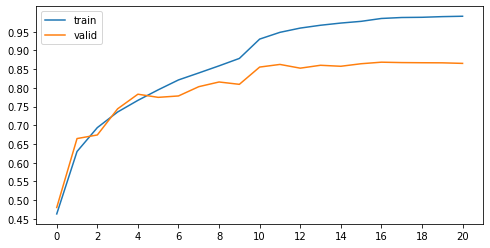

In [13]:
model.evaluate(test_images, test_oh_labels)
show_history(history)